## - Bayesian analysis for Stock Return Data
## - Build models for different distributions of data
## - Compare models

In this assignment, you will use the Baysesian approach for analysis of stock return data.
In particular, you will model the data as a normal distribution and will estimate distribution parameters using Markov chain Monte Carlo technique (MCMC).

**MCMC is a class of techniques for sampling from a probability distribution and can be used to estimate the distribution of parameters given a set of observations.**

The MCMC sampler draws parameter values from the prior distribution and computes the likelihood that the observed data came from a distribution with these parameter values.
It is recommended to use PyMC library for these computations; PyMC is a Python library for Bayesian analysis.

__NOTE__: The 'data.csv' file included contains the data.
The data were downloaded from Quandl, the code used to download data and calculate daily return is provided.    
Use that file instead if you aren't able to read the data, or if you have reached the limit for calls to the API.

__Getting data from Quandl__ 
To download stock data from Quandl you should create an account for quandl (https://www.quandl.com/).

Quandl is a platform for financial, economic, and alternative data that serves investment professionals. Quandl sources data from over 500 publishers. All Quandl's data are accessible via an API. API access is possible through packages for multiple programming languages including R, Python.

Required imports for this project are given below.  Make sure you have all libraries required for this project installed.  You may use _conda_ or _pip_ based on your set up.


In [1]:
#required imports

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import theano.tensor as tt
import seaborn as sns
from datetime import datetime

## Get the data:
pd.core.common.is_list_like = pd.api.types.is_list_like # resolves datareader error
from pandas_datareader import data
# For all libraries please install the necessary libraries 
#If the above fails, you might need to do something like this:
#This is to show how you install pandas-datareader, you might need to do this for all libraries
#conda install pandas-datareader
#or
#pip install pandas-datareader
#Depending on your setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import Image
from datetime import datetime
%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\Manjeet Kaur\AppData\Local\conda\conda\envs\deep-learning\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


After installing the necessary libraries, we will proceed to download the data.
You might have to set an environment variable for pymc3 package.  
You can do this by    
For linux:
export mkl_threading_layer=gnu or set this in your bashrc file.

For windows:
Add it in your environment variables

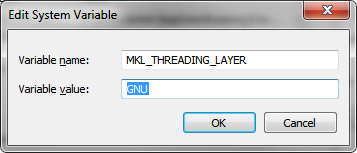

### Returns
Extract historical data for Apple (AAPL) [2015 - 2016], calculate daily returns, and estimate the mean daily return. Remove NaN from dataset. Plot histogram of daily returns.

Use code below to download data.

For this you will need to install the library quandl:    
conda install -c anaconda quandl

You will also need an API Key that is generated when you create an account.  

In [2]:
#Download data from Quandl
# import quandl
# quandl.ApiConfig.api_key = 'Quandl_API_KEY'

# data= quandl.get('WIKI/AAPL', start_date='2015-1-1', end_date='2016-12-31')
# print(type(data))

# data.to_csv('data.csv')

# Or just use file attached to assignment:

data = pd.read_csv('data.csv')

returns=data['Adj. Close'].pct_change()

returns = returns.dropna()*100
data.head()
returns.min()
returns.max()

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
0,2015-01-02,111.39,111.44,107.350,109.33,53204626.0,0.0,1.0,105.820966,105.868466,101.982949,103.863957,53204626.0
1,2015-01-05,108.29,108.65,105.410,106.25,64285491.0,0.0,1.0,102.875953,103.217954,100.139941,100.937944,64285491.0
2,2015-01-06,106.54,107.43,104.630,106.26,65797116.0,0.0,1.0,101.213446,102.058949,99.398938,100.947444,65797116.0
3,2015-01-07,107.20,108.20,106.695,107.75,40105934.0,0.0,1.0,101.840448,102.790453,101.360696,102.362951,40105934.0
4,2015-01-08,109.23,112.15,108.700,111.89,59364547.0,0.0,1.0,103.768957,106.542969,103.265455,106.295968,59364547.0


-6.570657065706264

6.496327712836347

#### Question 1

1. Plot the returns and draw a histogram to see the distribution


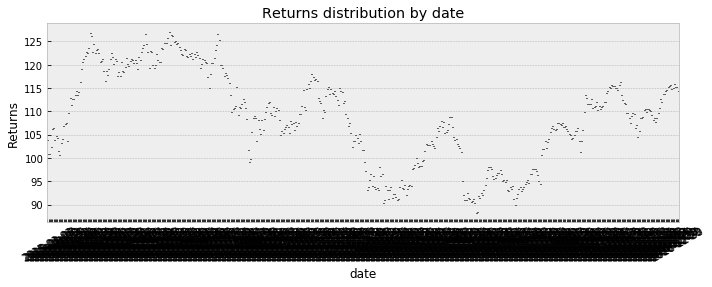

In [3]:
# YOUR CODE HERE
order = np.sort(data['Date'].unique())

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(211)

_ = sns.boxplot(x=data['Date'], y=data['Adj. Close'], order=order, orient="v", color=colors[6], linewidth=1, ax=ax)
_ = ax.set_title('Returns distribution by date')
_ = ax.set_xlabel('date')
_ = ax.set_ylabel('Returns')
_ = plt.xticks(rotation=30)

plt.tight_layout()

('Mean', 0.03166161960434796)

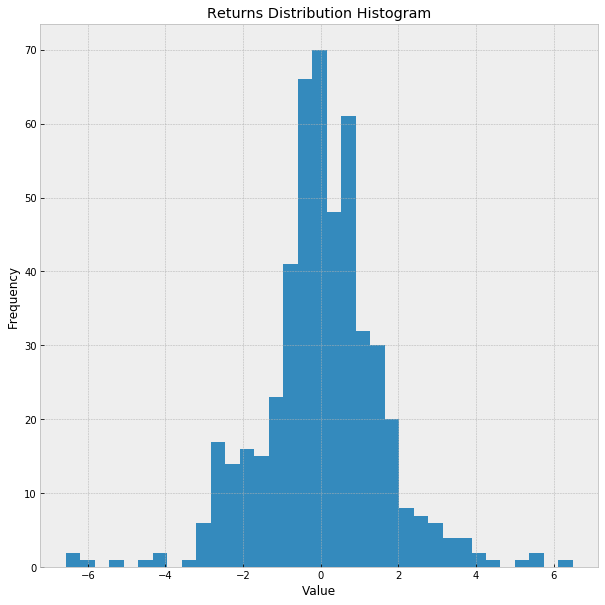

In [4]:
# YOUR CODE HERE
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
_ = ax.hist( returns,bins=35)
_ = ax.set_xlabel("Value")
_ = ax.set_ylabel("Frequency")
_ = ax.set_title("Returns Distribution Histogram")
mu_obs=returns.mean()
"Mean", mu_obs

In the cell below, the model for daily return simulations is shown. Since the daily returns histogram shows bell-shaped distribution, the normal distribution is used for likelihood computation.

This model uses un-informative priors - Uniform distribution for both parameters of the notmal distribution ("mu" and 'sigma").

In [5]:
with pm.Model() as model_n:
    #Prior
    

    mu = pm.Uniform("mu", lower=-10, upper=10, testval=0)
    sigma = pm.Uniform("sigma", lower=0, upper=6, testval=0.0001)
    
    #Likelihood
    likelihood = pm.Normal("likelihood", mu=mu, sd=sigma, observed = returns.values)
    
    #Posterior
    start = pm.find_MAP()
    step  = pm.Metropolis()
    trace = pm.sample(10000, step=step, start=start, progressbar=True)
    burned_trace = trace[3000::2]

logp = -969.97, ||grad|| = 483.7: 100%|██████████████████████████████████████████████| 37/37 [00:00<00:00, 1859.42it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 42000/42000 [00:15<00:00, 2697.74draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E6750996D8>,
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E674FAFEB8>,
      dtype=object)

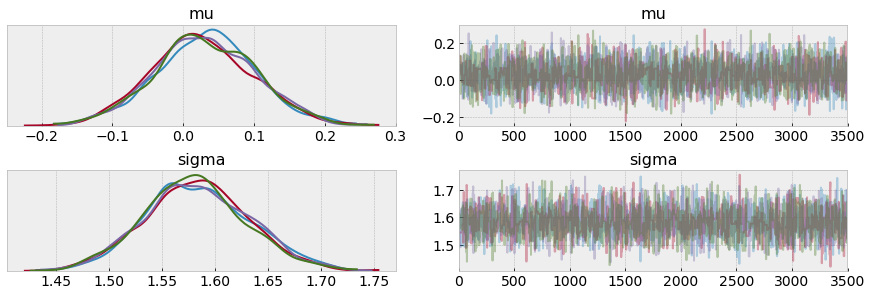

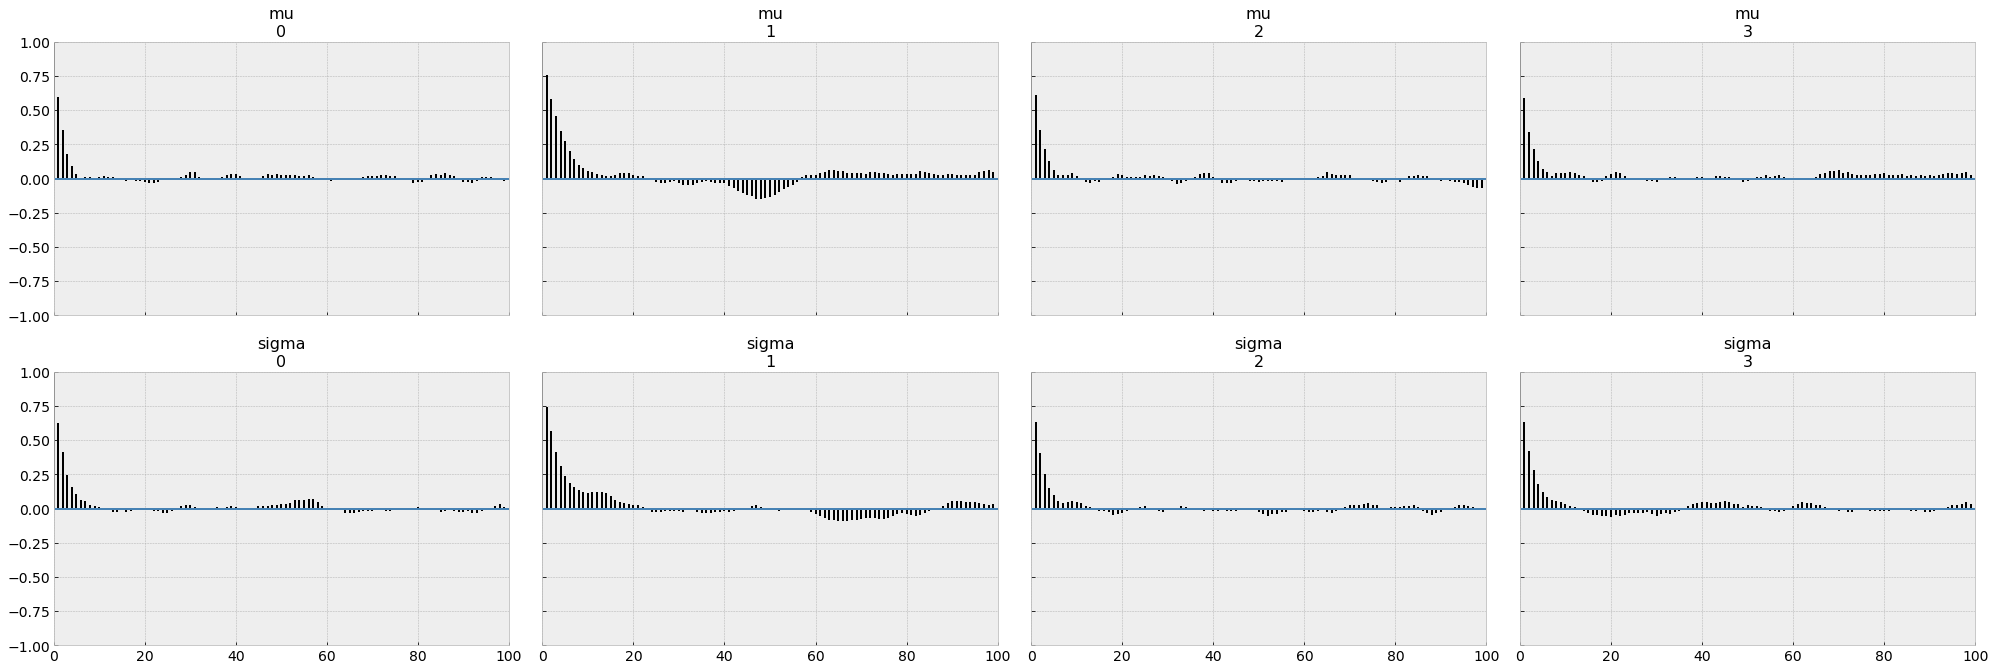

In [6]:
pm.traceplot(burned_trace, ['mu', 'sigma'])
pm.autocorrplot(burned_trace, ['mu', 'sigma'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E6763CCD68>,
      dtype=object)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.030,0.071,-0.112,0.159,0.001,0.001,2897.0,2339.0,2905.0,2536.0,1.0
sigma,1.583,0.049,1.487,1.671,0.001,0.001,2555.0,2552.0,2573.0,2678.0,1.0


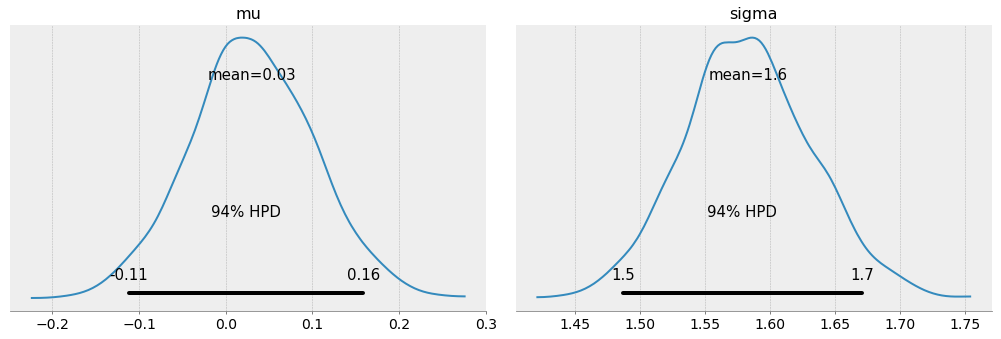

In [7]:
pm.plot_posterior(burned_trace)
pm.summary(burned_trace)

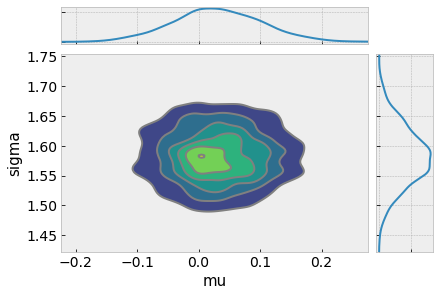

In [8]:
pm.plot_joint(burned_trace, kind='kde', fill_last=False);

In [9]:
pm.gelman_rubin(burned_trace)

C:\Users\Manjeet Kaur\AppData\Local\conda\conda\envs\deep-learning\lib\site-packages\pymc3\stats\__init__.py:43: UserWarning: gelman_rubin has been deprecated. In the future, use rhat instead.
  warnings.warn("gelman_rubin has been deprecated. In the future, use rhat instead.")


<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 1.003
    sigma    float64 1.002

#### Question 2

Improve the model for daily returns given above.
Choose different prior distributions for parameters of the likelihood distribution - Mean $\mu$ and Standard Deviation $\sigma$.

To tune the model, try several different distributions with various spread/dispersion values (for example, Uniform, Normal, HalfNormal) for priors, and different numbers of samples.
By inspecting posterior distribution of parameters, pick the value that produces the smoothest, most convergent chains. 

Present posterior distribution graphically. 

In [10]:
# YOUR CODE HERE
with pm.Model() as model_n:
    #Prior
    

#     mu = pm.Normal("mu")
#     sigma = pm.HalfNormal("sigma")
#     mu = pm.Normal('mu', mu=0.0, tau=0.05, testval=0.0)
    mu = pm.Uniform("mu", lower=-10, upper=10, testval=0)
    sigma = pm.HalfNormal('sigma', sd=5)
    #Likelihood
    likelihood = pm.Normal("likelihood", mu=mu, sd=sigma, observed = returns.values)
    
    #Posterior
    start = pm.find_MAP()
    step  = pm.Metropolis()
    trace = pm.sample(15000, step=step, start=start, progressbar=True)
    burned_trace = trace[5000::2]

logp = -1,202.7, ||grad|| = 424.91: 100%|██████████████████████████████████████████████| 9/9 [00:00<00:00, 2255.95it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 62000/62000 [00:23<00:00, 2638.91draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E600342B00>,
      dtype=object)

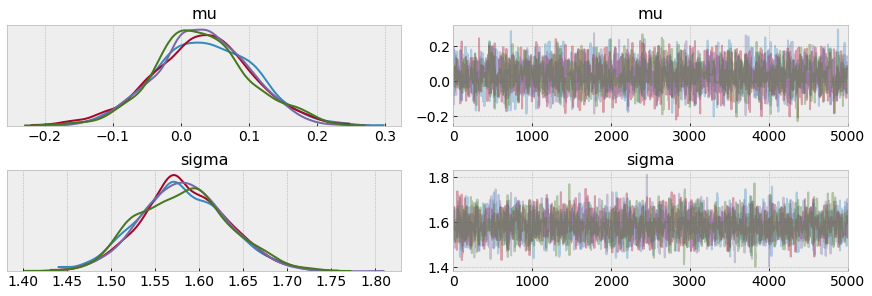

In [11]:
# SHOW TRACE PLOT
pm.traceplot(burned_trace, ['mu', 'sigma'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E600ED44E0>,
      dtype=object)

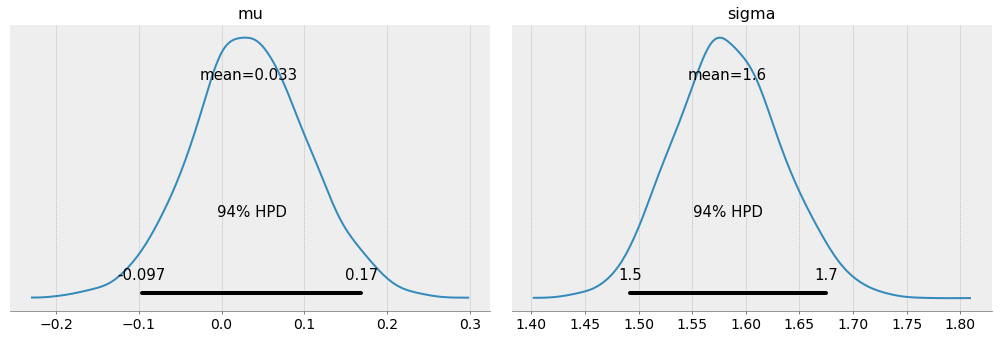

In [12]:
# PLOT POSTERIOR DISTRIBUTION
pm.plot_posterior(burned_trace)

In [13]:
pm.gelman_rubin(burned_trace)

C:\Users\Manjeet Kaur\AppData\Local\conda\conda\envs\deep-learning\lib\site-packages\pymc3\stats\__init__.py:43: UserWarning: gelman_rubin has been deprecated. In the future, use rhat instead.
  warnings.warn("gelman_rubin has been deprecated. In the future, use rhat instead.")


<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 1.005
    sigma    float64 1.003

#### Question 3

As a validation check of model performance, predict the distribution of daily returns from the obtained posterior distributions. To generate the data, use the pymc3 function for sampling posterior distribution with an appropriately chosen number of samples from the trace.

Present results of predicted distribution graphically as a histogram.

In [14]:
# Sample posterior to obtain the distribution of daily returns
ppc = pm.sample_posterior_predictive(burned_trace, samples=1000, model=model_n)
np.asarray(ppc['likelihood']).shape

C:\Users\Manjeet Kaur\AppData\Local\conda\conda\envs\deep-learning\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 783.77it/s]


(1000, 503)

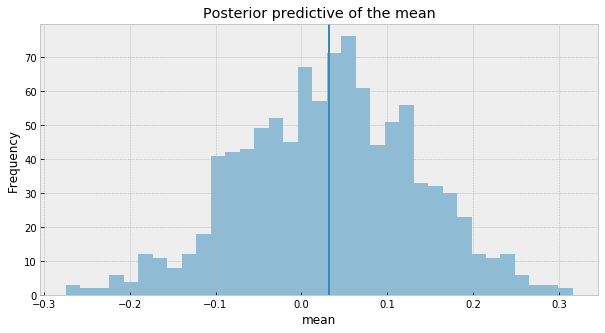

In [15]:
# Plot obtained distribution of daily return
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([likelihood.mean() for likelihood in ppc['likelihood']], bins=35, alpha=0.5)
ax.axvline(returns.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean', ylabel='Frequency');

### Question 4

(a) Identify the parameter of interest in the prediction model. What would be the best prior distribution to produce these parameters? 

(b) What is the HDI in the posteriors for the parameters you named in 4a? What number of samples was used to build this model? 

(c) Does the data generated when predicting daily returns from posterior distribution deviate significantly from the true distribution?

# YOUR ANSWERS TO 4(a-c).

a) "mu" and "sigma". I used the Uniform distribution for 'mu' and HalfNormal prior distribution for 'sigma'.

b) There is 94% probability the belief is between -0.091 and 0.17 for the mean return. 15,000 posterior samples were drawn using Metropolis sampling.

c) From the average plot the inferred mean is very close to the actual return mean.
